# How many layers?

Neutron reflectometry allows us to obtain structural information about layered materials, such as magnetic multilayers or biological membranes {cite}`toperverg_polarized_2015,gerelli_phase_2019`.
However, as with all scattering techniques, the recovery of structural information from a reflectometry dataset is an ill-posed problem. 
Hence the application of a model-dependent analysis approach. 

In this exercise, you will investigate the effect of instrumental background on the analysis of reflectometry data from a phospholipid monolayer. 
These systems can be modelled in a variety of different ways, however here we will focus on determining if we can describe it with either one or two layers (these are shown pictorially below, from the work of Campbell *et al.* {cite}`campbell_structure_2018`.)
These models can be either a single layer that describes the structure of the whole monolayer, or a pair of layers description the phospholipid head and tails groups individually.

![A picture showning the description of a phospholipid monolayer with one or two layers](./models.png)

There are four different data files that we will work with in the exercise, and for the reflectometry modelling we will use the Python package `refnx` {cite}`nelson_refnx_2019`. 
Let's first take a look at the data files, where hopefully see that as we increase from `data_0` to `data_3` the level of the background decreases. 

In [1]:
import matplotlib.pyplot as plt
import dynesty
from refnx_imports import *

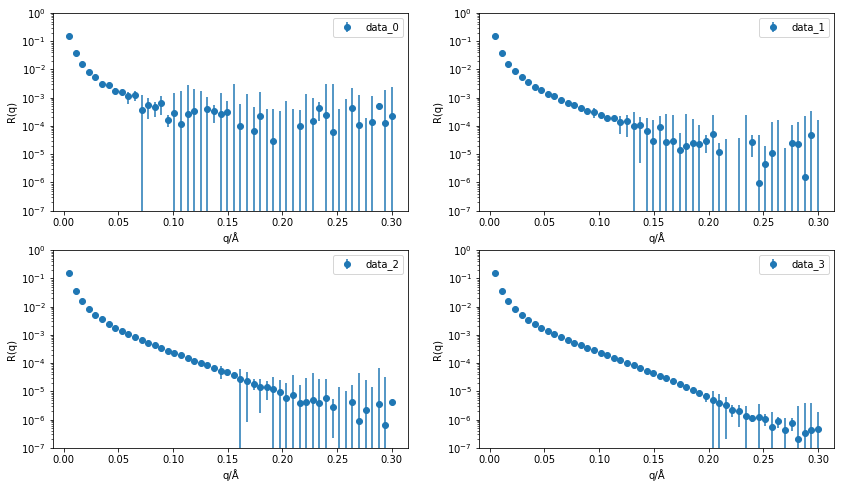

In [2]:
data = []
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
ax = ax.flatten()
for i in [0, 1, 2, 3]:
    data.append(ReflectDataset(f'data_{i}.dat'))
    ax[i].errorbar(data[i].x, data[i].y, data[i].y_err, marker='o', ls='', label=f'data_{i}')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('q/Å')
    ax[i].set_ylabel('R(q)')
    ax[i].set_ylim(1e-7, 1)
    ax[i].legend()
plt.show()

The focus of this exercise, is not to show you how to use the `refnx` package, so we have hidden some aspects of this within a piece of Python code (this is available [here](https://raw.githubusercontent.com/arm61/trad_ml_methods/main/refnx_imports.py)). 
We can import the fitting objective for each of the layers as shown below. 

In [3]:
objective1 = one_layer(data[0])
objective2 = two_layer(data[0])

We can visualise the structure of these two models by plotting the scattering length density as a function of the depth into the interface. 
Note, that there is some "interfacial roughness" between the layers, which is due to the interfaces between the layers not being atomically smooth (for example, water has an inherent roughness of ~3 Å). 
Typically this roughness value is the same for all of the individual layers in a monolayer system.

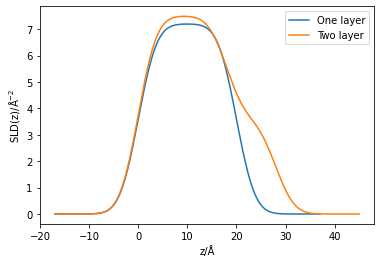

In [4]:
plt.plot(*objective1.model.structure.sld_profile(), label='One layer')
plt.plot(*objective2.model.structure.sld_profile(), label='Two layer')
plt.xlabel('z/Å')
plt.ylabel('SLD(z)/Å$^{-2}$')
plt.legend()
plt.show()

Let's look now at the parameters that will vary in each of the two models.

In [5]:
print(objective1.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:     'bkg'     , value=5e-06          , bounds=[1e-08, 0.001]>
<Parameter:'lipid - thick', value=20          , bounds=[22.0, 35.0]>


In [6]:
print(objective2.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:     'bkg'     , value=5e-06          , bounds=[1e-08, 0.001]>
<Parameter:'tail - thick' , value=18          , bounds=[15.0, 25.0]>
<Parameter:'head - thick' , value=10          , bounds=[7.0, 12.0]>


So the single layer only has two parameters that will vary in the model; the interfacial roughness and the thickness of the layer. 
While, the two layer model has a total of three parameters; as with the one layer, the interfacial roughness but also the head and tail layer thicknesses. 
We could compare the optimised solution for each of these models and see which has a better likelihood for the data. 
However, this would ignore the greater number of degrees of freedom in the two layer model. 
Therefore, we will use nested sampling to provide fairer methods of model comparison. 

The `refnx` package enables the use of dynesty easily. 
This is shown below for the data with the lowest background for the two layer model below. 

In [7]:
objective = two_layer(data[3])
nested = dynesty.NestedSampler(
    objective.logl, 
    objective.prior_transform, 
    ndim=len(objective.varying_parameters()))
nested.run_nested(print_progress=False)
print(nested.results['logz'][-1])

iter: 15195 | +500 | bound: 48 | nc: 1 | ncall: 53146 | eff(%): 29.532 | loglstar:   -inf < 653.142 <    inf | logz: 623.558 +/-  0.341 | dlogz:  0.001 >  0.509                                      

## Exercise

Find the Bayes factor, and therefore compare the one and two layer models at each of the different levels of background. 
Plot how the Bayes factor changes as the background level is increased, is there a point at which you can no longer say there is strong evidence for the more complex model?